# Frontloading

# Phase 2 vs. Phase 2

Following protocol from Gurr et al., “Acclimatory Gene Expression of Primed Clams Enhances Robustness to Elevated pCO2.” - who was originally inspired by Barshis et al., “Genomic Basis for Coral Resilience to Climate Change.”

[Gurr GitHub script](https://github.com/SamGurr/Pgenerosa_OA_TagSeq/blob/main/TagSeq/Analysis/Scripts/DE_frontloading.R)

## 0. load libraries

In [37]:
library(tidyverse)
library(reshape2)

## 1. read CSVs

#### DEGs

In [3]:
# get list of files
files <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/DEGs',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read each csv
deg_list <- lapply(files, read.csv)

# name list elements after the files
names(deg_list) <- gsub('DEG_','',tools::file_path_sans_ext(basename(files)))

# check things worked
names(deg_list)
head(deg_list$bb_cc)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

,X,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,⋯,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48,pair,DEG_group
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,726,LOC111134671,613.020976,1.705185,1.8602511,-3.890429,1.000673e-04,0.023871608,0.123867402,1623.040284,⋯,340.657679,46.877027,18.29407,181.5113,1580.693519,112.349708,34.203014,363.075510,CC vs. BB,BB
2,1086,LOC111120923,146.529937,-5.243692,4.1847160,3.947822,7.886530e-05,0.020048777,0.059178297,10.266500,⋯,182.671509,8.976452,0.00000,398.6953,184.147364,39.652838,5.344221,9.499069,CC vs. BB,CC
3,1148,LOC111136853,86.689266,-1.963764,2.6599338,3.713204,2.046516e-04,0.040461455,0.170868504,2.799954,⋯,3.702801,15.958137,0.00000,0.0000,6.862635,17.623484,2.137688,21.109041,CC vs. BB,CC
4,1221,LOC111120760,103.711700,2.616076,0.9408944,-4.651563,3.294284e-06,0.001389420,0.006801697,62.532317,⋯,30.856674,90.761903,197.57595,102.8214,81.207844,44.058709,40.616079,85.491617,CC vs. BB,BB
5,3058,LOC111125595,123.169520,17.307451,9.1757285,-4.195594,2.721571e-05,0.008903943,0.022714995,490.925353,⋯,0.000000,0.000000,0.00000,0.0000,0.000000,0.000000,0.000000,0.000000,CC vs. BB,BB
6,3219,LOC111114504,6.398528,7.268181,7.7009243,-3.710223,2.070769e-04,0.040461455,0.119596502,0.000000,⋯,0.000000,0.000000,0.00000,0.0000,19.444132,2.202935,0.000000,0.000000,CC vs. BB,BB


### all genes

In [4]:
# get list of files
files_all <- list.files(
    path = '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes',
    pattern = '\\.csv$',
    full.names = TRUE
    )

# read each csv
all_list <- lapply(files_all, read.csv)

# name list elements after the files
names(all_list) <- tools::file_path_sans_ext(basename(files_all))

# check things worked
names(all_list)
head(all_list$bb_cc)

[1] "bb_cc" "bc_bb" "bc_cc" "bc_hc" "bc_wc" "bh_ch" "bh_hh" "bw_cw" "bw_ww"
[10] "cb_bb" "cb_bc" "cb_cc" "cb_ch" "cb_cw" "ch_cc" "ch_hc" "cw_cc" "cw_ch"
[19] "cw_wc" "hb_bb" "hb_bh" "hb_cb" "hc_cc" "hc_hh" "hh_cc" "hh_ch" "wb_bb"
[28] "wb_bw" "wb_cb" "wc_cc" "wc_hc" "wc_ww" "wh_hw" "ww_cc" "ww_cw"

,X,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,svalue,B1_B1_O01,⋯,W4_W5_G56,W5_B2_G21,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48
,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,LOC111116054,8.9537018,-0.0202080595,0.12429017,1.2677121,0.20490079,0.9001718,0.9717822,1.866636,⋯,4.308183,2.436697,11.10840,1.994767,7.317628,5.245991,2.287545,20.92789,1.068844,0.0000
2,2,LOC111126949,558.9188428,0.0281683330,0.10245337,-1.2030773,0.22894641,0.9167464,0.9874444,825.986574,⋯,229.410737,540.946738,502.34665,738.063823,646.695362,425.974455,478.096882,467.02232,300.345215,632.2158
3,3,LOC111110729,112.7023690,-0.0317087955,0.09049763,1.0020605,0.31631439,0.9569395,0.9906581,59.732362,⋯,128.168440,61.729658,86.39869,148.610148,110.679121,120.657789,144.115328,118.95851,135.743211,224.8113
4,4,LOC111112434,7.0206931,0.0050885662,0.11328209,-0.4212178,0.67359602,0.9983941,0.9848650,10.266500,⋯,6.462274,0.000000,13.57694,5.984301,3.658814,0.000000,2.287545,17.62348,8.550753,0.0000
5,5,LOC111120752,427.4811709,-0.0732965248,0.12482504,2.1786669,0.02935642,0.5662278,0.9835328,335.994538,⋯,418.970782,284.281319,443.10184,344.097323,400.640125,291.677090,328.262692,458.21058,355.925113,453.8444
6,6,LOC111128944,0.1058866,0.0002957684,0.42423144,-0.0135484,0.98919027,0.9983941,0.9668732,0.000000,⋯,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000


## normalized counts check
In `DESeq2`, genes with raw counts of 0 have normalized counts of 0

I'm wondering how many genes have normalized zero counts?

In [30]:
norm.counts <- all_list$bb_cc[,-c(1,3:9)] # select only normalized counts columns
head(norm.counts)

,Gene,B1_B1_O01,B1_W5_O50,B2_B5_O51,B2_C4_O40,B3_B4_O41,B3_C3_O30,B3_C6_O66,B3_H4_O41,B3_W1_O06,⋯,W4_W5_G56,W5_B2_G21,W5_C4_G45,W5_H4_G46,W5_W2_G22,W6_B3_G35,W6_B4_G48,W6_H6_G71,W6_W3_G36,W6_W4_G48
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111116054,1.866636,5.925652,9.397297,7.773785,0.00000,11.67523,14.345577,9.244277,7.611847,⋯,4.308183,2.436697,11.10840,1.994767,7.317628,5.245991,2.287545,20.92789,1.068844,0.0000
2,LOC111126949,825.986574,471.089320,614.583255,506.159806,450.42615,416.80582,323.427565,554.656609,616.559623,⋯,229.410737,540.946738,502.34665,738.063823,646.695362,425.974455,478.096882,467.02232,300.345215,632.2158
3,LOC111110729,59.732362,91.847603,59.202974,86.375394,87.32752,114.41729,153.236851,185.912678,96.779200,⋯,128.168440,61.729658,86.39869,148.610148,110.679121,120.657789,144.115328,118.95851,135.743211,224.8113
4,LOC111112434,10.266500,1.975217,0.000000,1.727508,13.78856,17.51285,6.520717,36.977107,1.087407,⋯,6.462274,0.000000,13.57694,5.984301,3.658814,0.000000,2.287545,17.62348,8.550753,0.0000
5,LOC111120752,335.994538,331.836502,400.324872,303.177631,271.17493,324.57148,496.226567,383.123917,201.170247,⋯,418.970782,284.281319,443.10184,344.097323,400.640125,291.677090,328.262692,458.21058,355.925113,453.8444
6,LOC111128944,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,⋯,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000


In [19]:
dim(norm.counts) # 38,838 total genes

# rows will zero counts for all treatments
zero_expr <- norm.counts[rowSums(norm.counts[,c(2:97)]) == 0,] 
dim(zero_expr) # 3,426 genes with 0 counts

[1] 38838    97

[1] 3426   97

In [17]:
# percent of genes with 0 count?
dim(zero_expr)[1] / dim(norm.counts)[1] * 100

[1] 8.821258

so ~9% of genes in the data set have a normalized count of 0 across all phase 2 oysters

## 2. Frontloading!

### Step 1: pull up-regulated genes in oysters first exposed to control conditions
The first step in identifying frontloading is to pull genes that were up-regulated in oysters that were first exposed to control conditions, and then were exposed to stress (CW, CH, CB vs. CC)

(also going to do these steps simultaneously for warm, hypoxia, and both, but just focusing on frontloading within these stressors - not thinking about interactions of stressors yet)

In [20]:
# warm up-regulated
cw_cc.UP <- deg_list$cw_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(cw_cc.UP)

# hypoxia up-regulated
ch_cc.UP <- deg_list$ch_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(ch_cc.UP)

# both up-regulated
cb_cc.UP <- deg_list$cb_cc %>% filter(log2FoldChange > 0) %>% select(!X)
dim(cb_cc.UP)

[1]  71 106

[1]  72 106

[1]  80 106

70-80 up-regulated genes in each of these comparisons!

### Step 2: calculate mean expression for each treatment combo

In [21]:
metaData <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
mutate(All_treatment = factor(paste0(Phase1_treatment, '_', Phase2_treatment))) %>% # add column for p1 and p2 treatment combined, make treatment groups a factor
filter(!is.na(Phase2_treatment)) %>% # remove phase 1 samples
select(Sample, All_treatment) # grab only the needed columns 

dim(metaData)
head(metaData)

[1] 96  2

,Sample,All_treatment
,<chr>,<fct>
1,B1_B1_O01,both_both
2,B1_W5_O50,both_warm
3,B2_B5_O51,both_both
4,B2_C4_O40,both_control
5,B3_B4_O41,both_both
6,B3_C3_O30,both_control


In [35]:
# CW vs. CC - create "melted" or long-format df

cw_ccUP_melted <- cw_cc.UP %>% 
# select relevant columns
dplyr::select(
    Gene,
    where(is.numeric), # keeps all numeric columns
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
# convert from wide to long format
  reshape2::melt(id.vars = "Gene") %>% 
# renames column
  dplyr::rename(Sample = variable)

# merge meta data and melted df
cw_ccUP_TreatMerge <- merge(cw_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% # drop the sample column
                        dplyr::summarise(meanExp = mean(value)) # calculate mean expression

# convert back to wide format
# rows = genes
# cols = treatment groups
# values = mean expression
cw_ccUP_READY <- dcast(cw_ccUP_TreatMerge, Gene ~ All_treatment) %>%
select(Gene, control_warm, warm_control, warm_warm, control_control) # remove not needed cols

dim(cw_ccUP_READY)
head(cw_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



[1] 71  5

,Gene,control_warm,warm_control,warm_warm,control_control
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099630,1.616827,0.7917514,1.7590868,0.000000
2,LOC111099767,116.777773,7.8178809,7.3066780,2.478063
3,LOC111099906,1.532922,15.1819369,5.1914024,0.000000
4,LOC111099988,39.927130,0.0000000,205.7157310,0.000000
5,LOC111100493,31.817246,0.0000000,32.8103059,0.000000
6,LOC111100764,18.428817,0.0000000,0.1137982,0.000000


In [34]:
colSums(cw_ccUP_READY[,2:5] == 0, na.rm = TRUE)

control_warm    warm_control       warm_warm control_control 
              0               9               5              45

out of 71 upregulated genes in CW vs. CC, 45 of those have a normalized count of 0 in CC, so nearly half ...

In [39]:
# CH vs. CC
ch_ccUP_melted <- ch_cc.UP %>% 
dplyr::select(
    Gene,
    where(is.numeric),
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
  reshape2::melt(id.vars = "Gene") %>% 
  dplyr::rename(Sample = variable)

ch_ccUP_TreatMerge <- merge(ch_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% 
                        dplyr::summarise(meanExp = mean(value))

ch_ccUP_READY <- dcast(ch_ccUP_TreatMerge, Gene ~ All_treatment)  %>%
select(Gene, control_hypoxic, hypoxic_control, hypoxic_hypoxic, control_control) # remove not needed cols
head(ch_ccUP_READY)
dim(ch_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



,Gene,control_hypoxic,hypoxic_control,hypoxic_hypoxic,control_control
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099607,0.4869427,0.1531328,23.0189447,0
2,LOC111099630,13.8125540,0.3517412,105.0610495,0
3,LOC111099906,2.0076820,3.4511742,0.1495427,0
4,LOC111099988,19.0274892,0.0000000,11.3873180,0
5,LOC111100493,0.7248567,9.6728822,54.6591262,0
6,LOC111100764,0.6760772,0.0000000,0.6523815,0


[1] 72  5

In [41]:
colSums(ch_ccUP_READY[,2:5] == 0, na.rm = TRUE) 

control_hypoxic hypoxic_control hypoxic_hypoxic control_control 
              0              16               7              51

In [44]:
# CB vs. CC

cb_ccUP_melted <- cb_cc.UP %>% 
dplyr::select(
    Gene,
    where(is.numeric),
    -c(baseMean, log2FoldChange, lfcSE, stat, pvalue, padj, svalue)
  ) %>% 
  reshape2::melt(id.vars = "Gene") %>% 
  dplyr::rename(Sample = variable)

cb_ccUP_TreatMerge <- merge(cb_ccUP_melted, metaData, by = 'Sample') %>% 
                        dplyr::group_by(Gene, All_treatment) %>% 
                        dplyr::select(!'Sample') %>% 
                        dplyr::summarise(meanExp = mean(value))

cb_ccUP_READY <- dcast(cb_ccUP_TreatMerge, Gene ~ All_treatment) %>%
select(Gene, control_both, both_control, both_both, control_control) # remove not needed cols
head(cb_ccUP_READY)
dim(cb_ccUP_READY)

`summarise()` has grouped output by 'Gene'. You can override using the
`.groups` argument.
Using meanExp as value column: use value.var to override.



,Gene,control_both,both_control,both_both,control_control
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,LOC111099607,1.6702917,14.037035,47.564975,0.000000
2,LOC111099630,0.5384872,209.807496,30.997073,0.000000
3,LOC111099705,83.0015834,7.471397,4.754348,5.030481
4,LOC111099906,0.1611699,1.219780,1.249137,0.000000
5,LOC111099988,148.9589347,87.796753,0.000000,0.000000
6,LOC111100493,14.7580009,20.015540,15.967131,0.000000


[1] 80  5

In [43]:
colSums(cb_ccUP_READY[,2:5] == 0, na.rm = TRUE) # 46 genes with 0 expr. in CC - little over half

control_both    both_control       both_both control_control 
              0               3               9              46

a problem arises later on because there is a 0 count for some of the genes, so the returned ratio of ratios is Inf

could add a **pseudocount** - since we calculate a ratio-of-ratios, this shouldn't affect the results/data (should cancel out), just allows up to visualize and pick up on constitutive frontloading or reduced response genes

### 2b. add pseudocount

In [62]:
cw_ccUP_pseudo <- cw_ccUP_READY %>%
  mutate(across(2:5, ~ .x + 1))

ch_ccUP_pseudo <- ch_ccUP_READY %>%
  mutate(across(2:5, ~ .x + 1))

cb_ccUP_pseudo <- cb_ccUP_READY %>%
  mutate(across(2:5, ~ .x + 1))

### Step 3: calculate x and y axis of frontloading figure using normalized counts
input dfs:
- cw_ccUP_pseudo
- ch_ccUP_pseudo
- cb_ccUP_pseudo

#### X axis
this is the relative fold ratio of the stress-control to the control-control as the following: 

[ (HH/HC) / (CH/CC) ]

values <1 indicate genes that are lower response to stress than phase 1 control oysters (opposite for values >1)

In [63]:
## WARM ##
w.xall_1 <- ( (cw_ccUP_pseudo$warm_warm / cw_ccUP_pseudo$warm_control) / (cw_ccUP_pseudo$control_warm / cw_ccUP_pseudo$control_control) ) # call WC as control for WW ratio
w.xall_2 <- ( (cw_ccUP_pseudo$warm_warm / cw_ccUP_pseudo$control_control) / (cw_ccUP_pseudo$control_warm / cw_ccUP_pseudo$control_control) ) # call CC as control for WW ratio
w.xall_3 <- (cw_ccUP_pseudo$warm_warm / cw_ccUP_pseudo$control_warm) # call CC as control for WW ratio

cw_ccUP_pseudo$xall_1 <- w.xall_1
cw_ccUP_pseudo$xall_2 <- w.xall_2
cw_ccUP_pseudo$xall_3 <- w.xall_3

In [64]:
## HYPOXIA ##
h.xall_1 <- ( (ch_ccUP_pseudo$hypoxic_hypoxic / ch_ccUP_pseudo$hypoxic_control) / (ch_ccUP_pseudo$control_hypoxic / ch_ccUP_pseudo$control_control) ) # call HC as control for HH ratio
h.xall_2 <- ( (ch_ccUP_pseudo$hypoxic_hypoxic / ch_ccUP_pseudo$control_control) / (ch_ccUP_pseudo$control_hypoxic / ch_ccUP_pseudo$control_control) ) # call CC as control for HH ratio
h.xall_3 <- (ch_ccUP_pseudo$hypoxic_hypoxic / ch_ccUP_pseudo$control_hypoxic) # call CC as control for HH ratio

ch_ccUP_pseudo$xall_1 <- h.xall_1
ch_ccUP_pseudo$xall_2 <- h.xall_2
ch_ccUP_pseudo$xall_3 <- h.xall_3

In [65]:
## BOTH ##
b.xall_1 <- ( (cb_ccUP_pseudo$both_both / cb_ccUP_pseudo$both_control) / (cb_ccUP_pseudo$control_both / cb_ccUP_pseudo$control_control) ) # call BC as control for BB ratio
b.xall_2 <- ( (cb_ccUP_pseudo$both_both / cb_ccUP_pseudo$control_control) / (cb_ccUP_pseudo$control_both / cb_ccUP_pseudo$control_control) ) # call CC as control for BB ratio
b.xall_3 <- (cb_ccUP_pseudo$both_both / cb_ccUP_pseudo$control_both) # call CC as control for BB ratio

cb_ccUP_pseudo$xall_1 <- b.xall_1
cb_ccUP_pseudo$xall_2 <- b.xall_2
cb_ccUP_pseudo$xall_3 <- b.xall_3

#### Y axis
this is stress-control over control-control

( HC / CC)


In [66]:
## WARM ##
w.yall <- (cw_ccUP_pseudo$warm_control / cw_ccUP_pseudo$control_control)
cw_ccUP_pseudo$yall <- w.yall

## HYPOXIA ##
h.yall <- (ch_ccUP_pseudo$hypoxic_control / ch_ccUP_pseudo$control_control)
ch_ccUP_pseudo$yall <- h.yall

## BOTH ##
b.yall <- (cb_ccUP_pseudo$both_control / cb_ccUP_pseudo$control_control)
cb_ccUP_pseudo$yall <- b.yall

### Step 4: plot it!

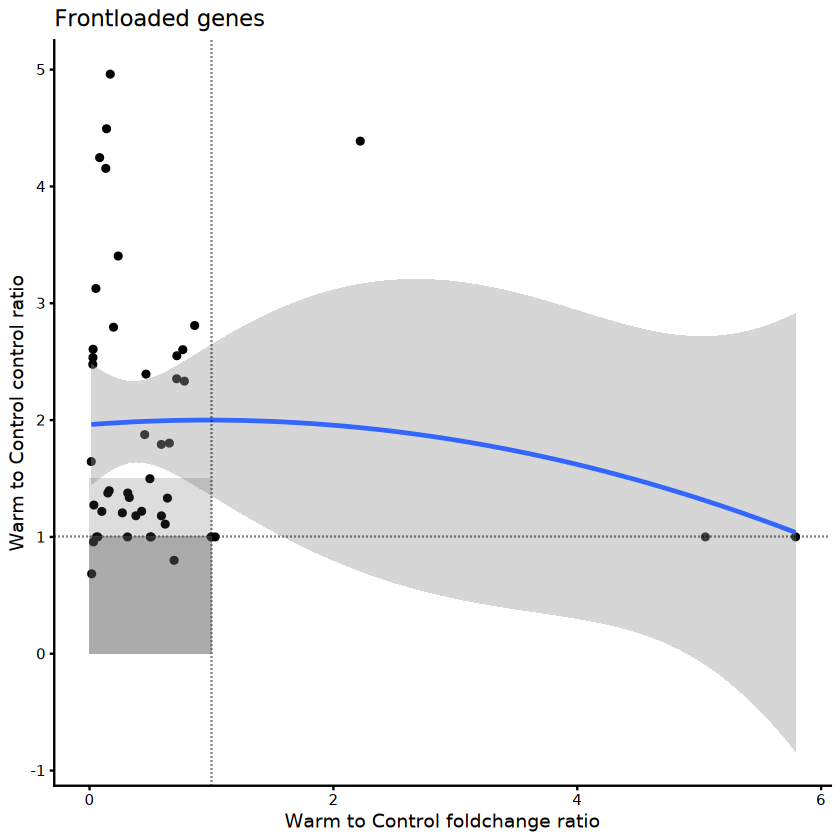

In [67]:
W <- cw_ccUP_pseudo %>% dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Warm to Control control ratio", 
             x = "Warm to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5)
W

In [76]:
# call genes with x axis vaulue < 1
warm_frontloaded_genes <- cw_ccUP_pseudo %>% 
  dplyr::filter(xall_1 < 1) %>% 
  dplyr::filter(yall > 1) %>% 
  dplyr::select('Gene') # %>% 
# dplyr::filter(yall < 1) 

dim(cw_ccUP_pseudo) # 71 genes total
dim(warm_frontloaded_genes) # 58 front-loaded?

[1] 71  9

[1] 58  1

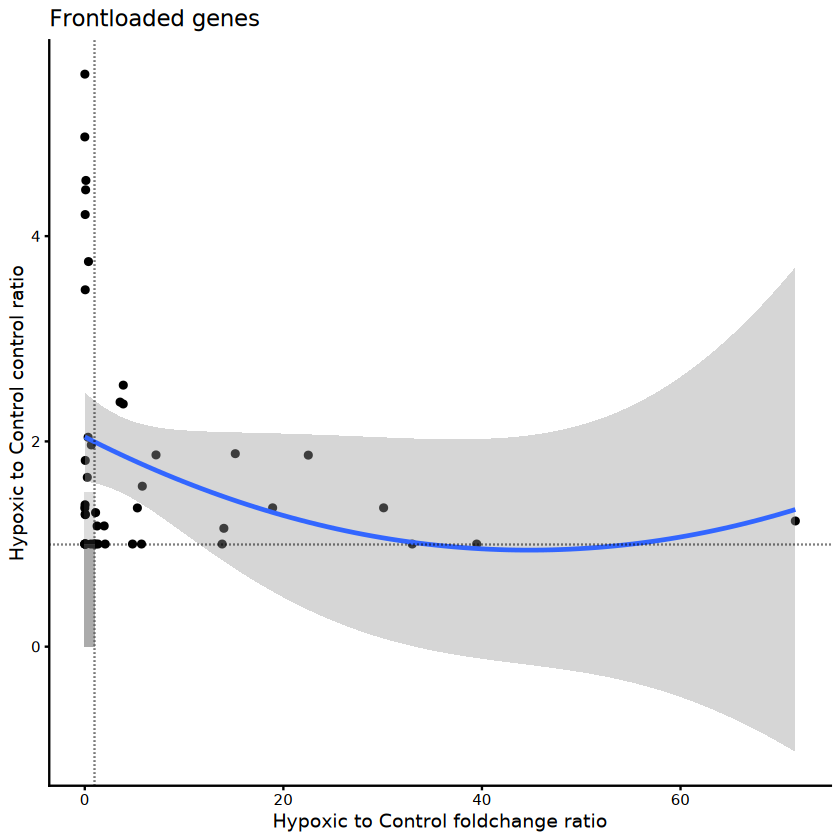

In [68]:
H <- ch_ccUP_pseudo %>% dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Hypoxic to Control control ratio", 
             x = "Hypoxic to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1.5,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5)
H

In [75]:
# call genes with x axis vaulue < 1
hypoxic_frontloaded_genes <- ch_ccUP_pseudo %>% 
  dplyr::filter(xall_1 < 1) %>% 
  dplyr::filter(yall > 1) %>% 
  dplyr::select('Gene') # %>% 
# dplyr::filter(yall < 1) 

dim(ch_ccUP_pseudo) # 72 genes total
dim(hypoxic_frontloaded_genes) # 38 front-loaded?

[1] 72  9

[1] 38  1

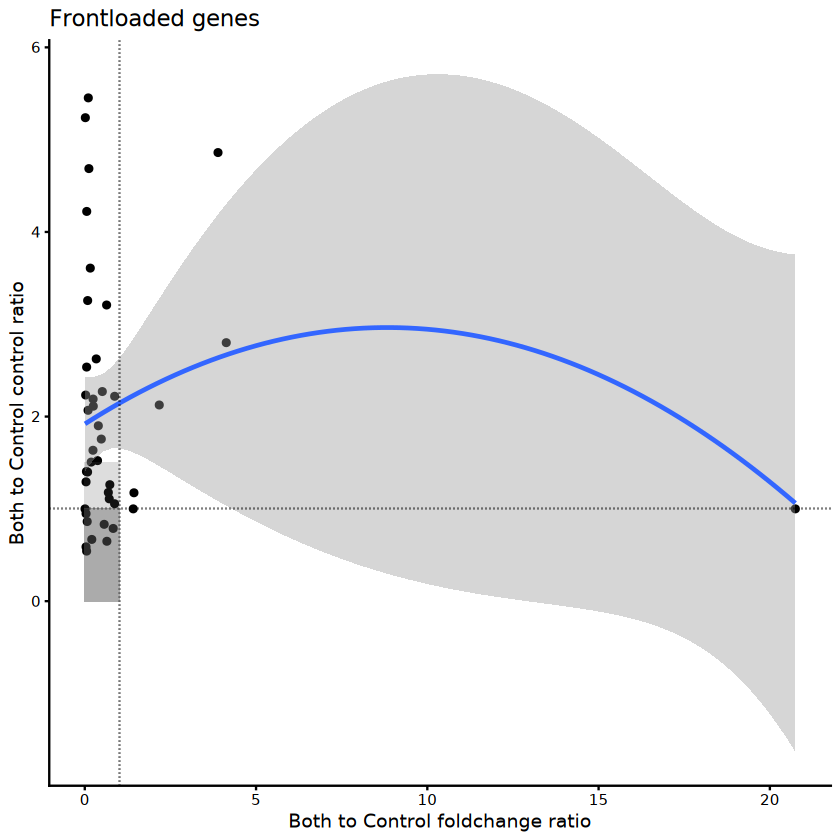

In [69]:
B <- cb_ccUP_pseudo %>% dplyr::filter(yall < 6) %>% 
        ggplot(aes(x=xall_1, y=yall)) +
        geom_point() +
        theme_classic() + 
        stat_smooth(method = "lm", 
                    formula = y ~ x + poly(x, 2) - 1) +
        geom_vline(xintercept=1, linetype="dotted") + 
        geom_hline(yintercept=1, linetype="dotted") + 
        labs(y= "Both to Control control ratio", 
             x = "Both to Control foldchange ratio",
             title = "Frontloaded genes") + 
        expand_limits(x = 0, y = 0) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 1, ymax = 1.5,
           alpha = .2) + 
  annotate("rect", xmin = 0, xmax = 1, ymin = 0, ymax = 1,
           alpha = .5)
B

In [73]:
# call genes with x axis vaulue < 1
both_frontloaded_genes <- cb_ccUP_pseudo %>% 
  dplyr::filter(xall_1 < 1) %>% 
  dplyr::filter(yall > 1) %>% 
  dplyr::select('Gene') # %>% 
# dplyr::filter(yall < 1) 

dim(cb_ccUP_pseudo) # 80 genes total
dim(both_frontloaded_genes) # 64 front-loaded?

[1] 80  9

[1] 64  1